In [1]:
import datetime
import backtrader as bt
import pandas as pd
# import yfinance as yf
import matplotlib.pyplot as plt

Failed to get ticker 'AAPL' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
Failed to get ticker 'META' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['META']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
Failed to get ticker 'GOOGL' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GOOGL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
Failed to get ticker 'NFLX' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NFLX']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
Failed to get tick

Portfolio Values:
 Empty DataFrame
Columns: [TotalValue]
Index: []
Factor Exposures:
 Empty DataFrame
Columns: []
Index: []


TypeError: no numeric data to plot

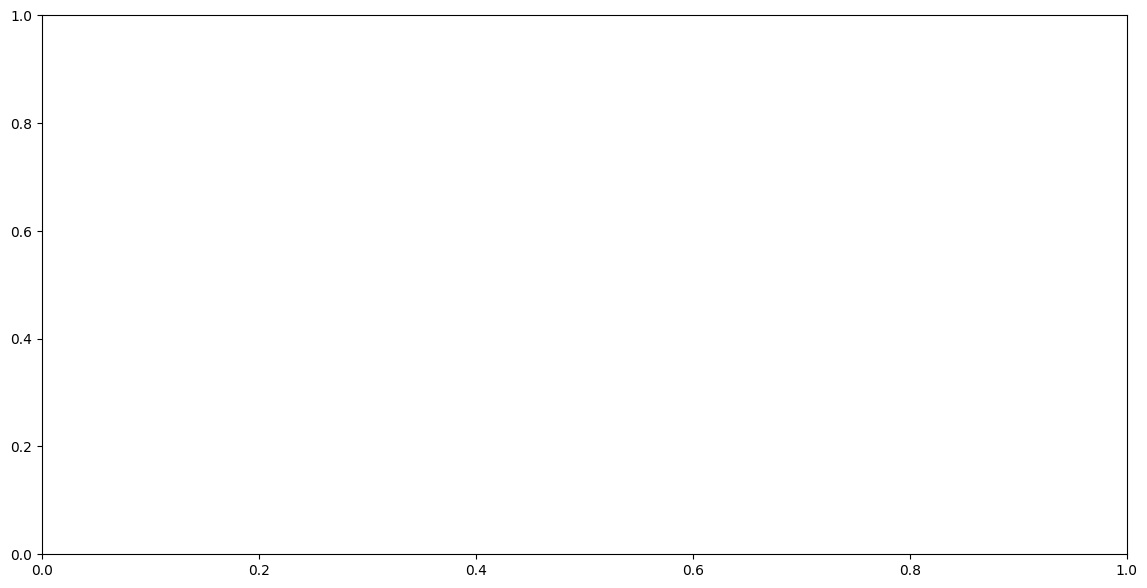

In [5]:
import datetime
import backtrader as bt
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt  # Correct import

class AnnualRebalanceStrategy(bt.Strategy):
    params = (
        ("allocations", {
            "AAPL": 0.20,
            "META": 0.30,
            "GOOGL": 0.10,
            "NFLX": 0.20,
            "NVDA": 0.20,
        }),
    )

    def __init__(self):
        self.last_rebalance = None
        self.portfolio_values = {}  # Dictionary to store portfolio values
        self.factor_exposures = {}  # Dictionary to store factor exposures
        self.factor_returns = {}  # Dictionary to store factor returns

    def log(self, txt, dt=None):
        """ Logging function for this strategy"""
        dt = dt or self.data.datetime[0]
        if isinstance(dt, float):
            dt = bt.num2date(dt)
        print("%s, %s" % (dt.date(), txt))

    def next(self):
        # Get the current date
        current_date = self.data.datetime.date()

        # Record the portfolio value
        total_value = self.broker.getvalue()
        self.portfolio_values[current_date] = total_value

        # Calculate factor exposures
        self.calculate_factor_exposures()

        # Check if it's the first trading day of the year
        if self.last_rebalance is None or current_date.year > self.last_rebalance.year:
            self.log(f"Rebalancing on {current_date}")
            self.rebalance_portfolio()
            self.last_rebalance = current_date

    def calculate_factor_exposures(self):
        # Calculate factor exposures, e.g., allocation to each stock
        exposures = {d._name: d.getbroker().getvalue(d) / self.broker.getvalue() for d in self.datas}
        self.factor_exposures[self.data.datetime.date()] = exposures

    def rebalance_portfolio(self):
        # Get the total value of the portfolio
        total_value = self.broker.getvalue()

        for d in self.datas:
            ticker = d._name
            target_allocation = self.p.allocations.get(ticker, 0)
            target_value = total_value * target_allocation
            current_value = d.getbroker().getvalue(d)

            # Calculate the number of units to buy/sell
            units_to_trade = (target_value - current_value) / d.close[0]

            if units_to_trade > 0:
                self.buy(d, size=units_to_trade)
            elif units_to_trade < 0:
                self.sell(d, size=abs(units_to_trade))

class YahooFinanceData(bt.feeds.PandasData):
    @staticmethod
    def download_data(ticker, start, end):
        return yf.download(ticker, start=start, end=end)

if __name__ == "__main__":
    cerebro = bt.Cerebro()

    # Add the data feeds for each stock
    tickers = ["AAPL", "META", "GOOGL", "NFLX", "NVDA"]
    for ticker in tickers:
        df = YahooFinanceData.download_data(ticker, "2024-01-01", "2024-07-31")
        data = YahooFinanceData(dataname=df)
        cerebro.adddata(data, name=ticker)

    cerebro.addstrategy(AnnualRebalanceStrategy)
    cerebro.broker.setcash(1000000)

    # Execute the backtest
    results = cerebro.run()

    # Access the strategy instance
    strategy = results[0]

    # Convert portfolio_values and factor_exposures to DataFrames
    portfolio_df = pd.DataFrame(list(strategy.portfolio_values.items()), columns=['Date', 'TotalValue'])
    portfolio_df.set_index('Date', inplace=True)

    factor_exposures_df = pd.DataFrame(strategy.factor_exposures).T

    print("Portfolio Values:\n", portfolio_df.head())
    print("Factor Exposures:\n", factor_exposures_df.head())

    # Plotting
    plt.figure(figsize=(14, 7))
    portfolio_df['TotalValue'].plot(label='Total Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value ($)')
    plt.legend()
    plt.show()

    # Plot Factor Exposures
    factor_exposures_df.plot(kind='bar', stacked=True, figsize=(14, 7))
    plt.title('Factor Exposures Over Time')
    plt.xlabel('Date')
    plt.ylabel('Exposure')
    plt.legend(title='Ticker')
    plt.show()


In [22]:
# 导入需要的模块
# 若无相关module, 可以在jupyter note中可以 ! pip install <模块名>
import requests
import re
import numpy as np
import pandas as pd
import matplotlib as plt
from bs4 import BeautifulSoup
import datetime
import backtrader as bt
import pandas as pd
import yfinance as yf

In [2]:
# 定义获取天天基金html的函数
# 该函数也是参考别的大神写的
# 该函数用于访问指定url，即按照基金代码、开始和截止日期访问到相应的页面
def get_html(code, start_date, end_date, page=1, per=20):
    ''' 需要输入的参数为code:即基金代码，starte_date: 开始日期'''
    '''end_date：结束日期'''
    url = 'http://fund.eastmoney.com/f10/F10DataApi.aspx?type=lsjz&code={0}&page={1}&sdate={2}&edate={3}&per={4}'.format(
        code, page, start_date, end_date, per)
    rsp = requests.get(url)
    html = rsp.text
    return html


# 定义获取基金数值的函数
# 通过上文的get_html函数访问到相应的页面后，需要通过beautifulsoup对html页面进行解析
# 解析后的数据写入dataframe, 并进行返回
def get_fund(code, start_date, end_date, page=1, per=20):
    # 获取html
    html = get_html(code, start_date, end_date, page, per)
    soup = BeautifulSoup(html, 'html.parser')
    # 获取总页数
    pattern = re.compile('pages:(.*),')
    result = re.search(pattern, html).group(1)
    total_page = int(result)
    # 获取表头信息
    heads = []
    for head in soup.findAll("th"):
        heads.append(head.contents[0])
 
 
    # 数据存取列表
    records = []
    # 获取每一页的数据
    current_page = 1
    while current_page <= total_page:
        html = get_html(code, start_date, end_date, current_page, per)
        soup = BeautifulSoup(html, 'html.parser')
        # 获取数据
        for row in soup.findAll("tbody")[0].findAll("tr"):
            row_records = []
            for record in row.findAll('td'):
                val = record.contents
                # 处理空值
                if val == []:
                    row_records.append(np.nan)
                else:
                    row_records.append(val[0])
            # 记录数据
            records.append(row_records)
        # 下一页
        current_page = current_page + 1
 
 
    # 将数据转换为Dataframe对象
    np_records = np.array(records)
    fund_df = pd.DataFrame()
    for col, col_name in enumerate(heads):
        fund_df[col_name] = np_records[:, col]
 
 
    # 按照日期排序
    fund_df['净值日期'] = pd.to_datetime(fund_df['净值日期'])
    fund_df = fund_df.sort_values(by='净值日期', axis=0, ascending=True).reset_index(drop=True)
    fund_df = fund_df.set_index('净值日期')
 
 
    # 数据类型处理
    fund_df['单位净值'] = fund_df['单位净值'].astype(float)
    fund_df['累计净值'] = fund_df['累计净值'].astype(float)
    fund_df['日增长率'] = fund_df['日增长率'].str.strip('%').astype(float)
    return fund_df

In [3]:
#需要获取的基金代码
my_dict={'广发纳指100':'270042',
     '银河收益混合':'151002',
     '易方达稳健收益B':'110008',
     '易方达安心回报债券A':'110027'}

# 此代码用于将上文提及的基金名称、代码等，由字典类型转换成 dataframe类型
my_df = pd.DataFrame.from_dict(my_dict, orient='index',columns=['code'])
my_df=my_df.reset_index().rename(columns={'index':'name'})

In [4]:
# 先创立一个local化的变量，用于在for循环中自动创建dataframe
fund_df_=locals()
for i in range(len(my_df)):
    # 根据输入的基金名称和数量，自动创建相应个数的dataframe
#     fund_df_[my_df['code'][i]]=pd.DataFrame()
    fund_df_[my_df['code'][i]] = pd.read_excel(my_df['name'][i]+'.xlsx',index_col=0)
    # 获取基金数据
#     fund_df_[my_df['code'][i]]=get_fund(my_df['code'][i],start_date='2020-01-01',end_date='2024-08-31')
    # 将基金数据作为xlsx文件写入本地
#     fund_df_[my_df['code'][i]].to_excel(my_df['name'][i]+'.xlsx')

2020-12-25, Initial Cash: 1000000
2014-02-07, Total Value: 1000000.0
2014-02-07, Rebalancing on 2014-02-07
2014-02-07, Total Value: 1000000.0
2014-02-07, Ticker: 270042, Position Size: 0, Current Value: 0.0
2014-02-07, Target Value: 200000.0, Units to Trade: 162733.93002441007
2014-02-07, Buying 162733.93002441007 units of 270042 at 1.229
2014-02-07, Ticker: 151002, Position Size: 0, Current Value: 0.0
2014-02-07, Target Value: 300000.0, Units to Trade: 138153.3502187428
2014-02-07, Buying 138153.3502187428 units of 151002 at 2.1715
2014-02-07, Ticker: 110008, Position Size: 0, Current Value: 0.0
2014-02-07, Target Value: 100000.0, Units to Trade: 71983.87561186294
2014-02-07, Buying 71983.87561186294 units of 110008 at 1.3892
2014-02-07, Ticker: 110027, Position Size: 0, Current Value: 0.0
2014-02-07, Target Value: 200000.0, Units to Trade: 174825.17482517485
2014-02-07, Buying 174825.17482517485 units of 110027 at 1.144
2014-02-10, Total Value: nan
2014-02-10, Invalid total value, sk

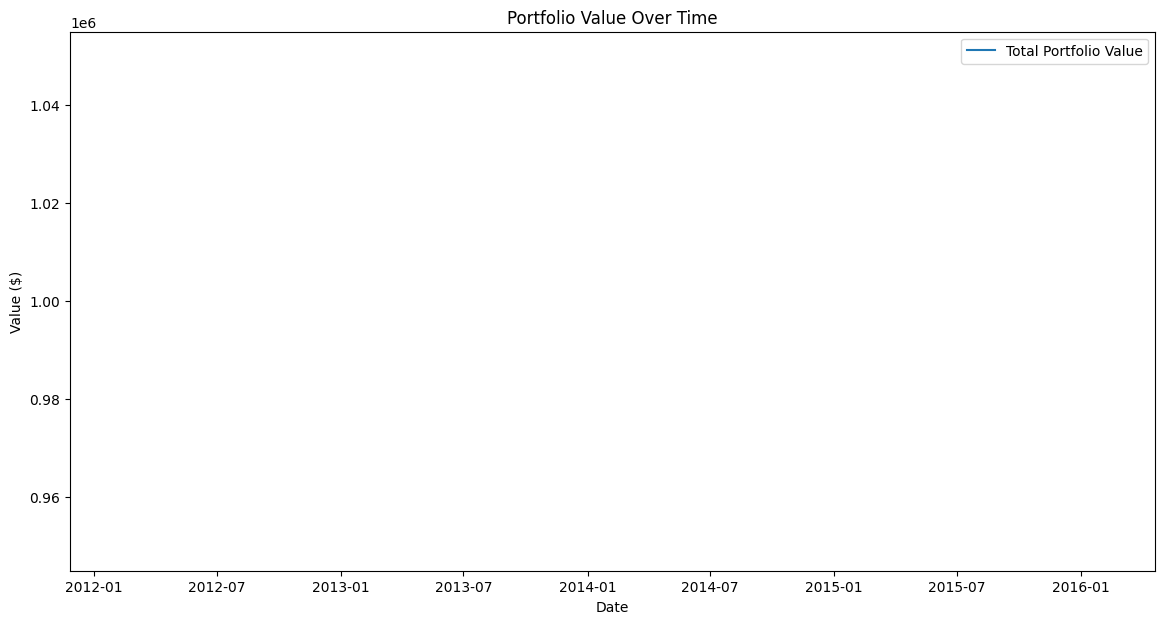

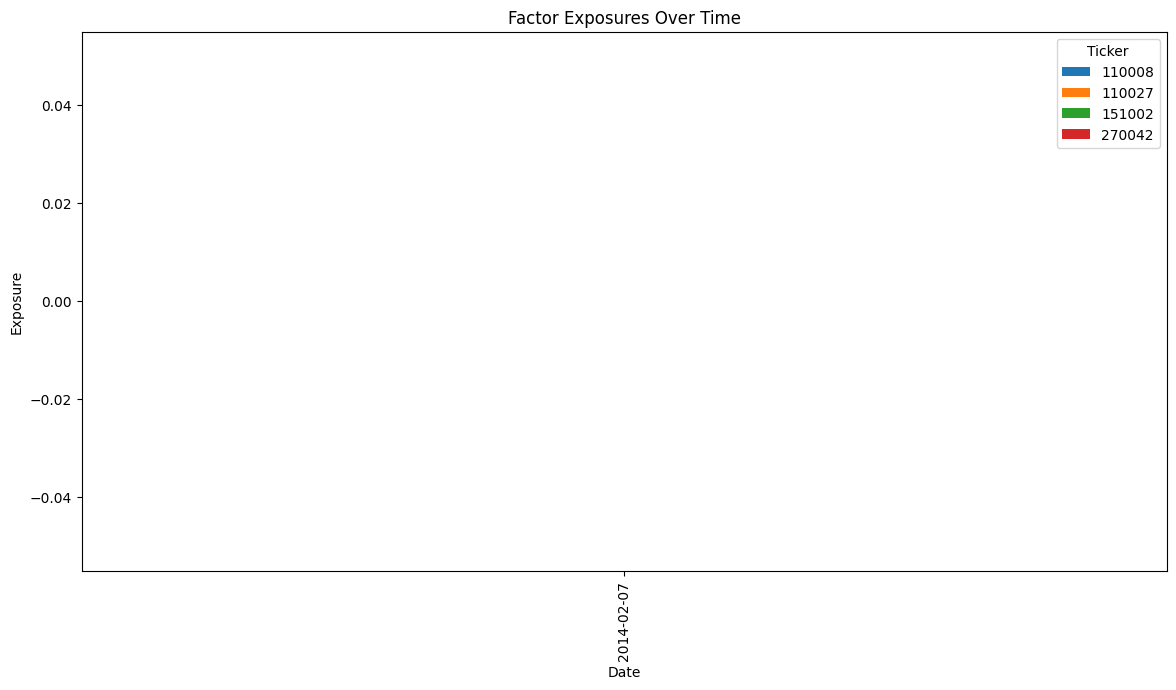

In [87]:
import datetime
import backtrader as bt
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt  # Correct import

class AnnualRebalanceStrategy(bt.Strategy):
    params = (
        ("allocations", {
            "270042": 0.20,
            "151002": 0.30,
            "110008": 0.10,
            "110027": 0.20
        }),
    )

    def __init__(self):
        self.last_rebalance = None
        self.portfolio_values = {}  # Dictionary to store portfolio values
        self.factor_exposures = {}  # Dictionary to store factor exposures
        self.factor_returns = {}  # Dictionary to store factor returns
        
        # Log initial cash value
        self.log(f"Initial Cash: {self.broker.getcash()}")

    def log(self, txt, dt=None):
        """ Logging function for this strategy"""
        dt = dt or self.data.datetime[0]
        if isinstance(dt, float):
            dt = bt.num2date(dt)
        print("%s, %s" % (dt.date(), txt))

    def calculate_factor_exposures(self):
        # Calculate factor exposures, e.g., allocation to each stock
        total_value = self.broker.getvalue()
        exposures = {}
        for d in self.datas:
            # Assuming each data feed represents a stock or fund
            # Get the current value of each data feed in the portfolio
            # Here we use the current price to estimate the value
            current_value = d.close[0] * self.broker.getposition(d).size
            exposures[d._name] = current_value / total_value
        self.factor_exposures[self.data.datetime.date()] = exposures

    def rebalance_portfolio(self):
        # Get the total value of the portfolio
        total_value = self.broker.getvalue()
        
        # Check if the total value is valid
        if pd.isna(total_value) or total_value <= 0:
            self.log(f"Invalid total value: {total_value}, skipping rebalance.")
            return
        
        self.log(f"Total Value: {total_value}")
        
        for d in self.datas:
            ticker = d._name
            target_allocation = self.p.allocations.get(ticker, 0)
            target_value = total_value * target_allocation
            
            # Get the current position size and current NAV or cumulative NAV
            position = self.getposition(d)
            current_value = position.size * d.close[0]  # Calculate the current value of the position
    
            # Calculate the number of units to buy/sell
            units_to_trade = (target_value - current_value) / d.close[0]
    
            # Log the details
            self.log(f"Ticker: {ticker}, Position Size: {position.size}, Current Value: {current_value}")
            self.log(f"Target Value: {target_value}, Units to Trade: {units_to_trade}")
    
            if units_to_trade > 0:
                self.log(f"Buying {units_to_trade} units of {ticker} at {d.close[0]}")
                self.buy(data=d, size=units_to_trade, price=d.close[0], exectype=bt.Order.Market)
            elif units_to_trade < 0:
                self.log(f"Selling {-units_to_trade} units of {ticker} at {d.close[0]}")
                self.sell(data=d, size=abs(units_to_trade), price=d.close[0], exectype=bt.Order.Market)
    
    def next(self):
        # Get the current date
        current_date = self.data.datetime.date()
        
        # Record the portfolio value
        total_value = self.broker.getvalue()
        
        # Log total value
        self.log(f"Total Value: {total_value}")
        
        if pd.isna(total_value) or total_value <= 0:
            self.log("Invalid total value, skipping rebalance.")
            return
        
        self.portfolio_values[current_date] = total_value
        
        # Calculate factor exposures
        self.calculate_factor_exposures()
        
        # Check if it's the first trading day of the year
        if self.last_rebalance is None or current_date.year > self.last_rebalance.year:
            self.log(f"Rebalancing on {current_date}")
            self.rebalance_portfolio()
            self.last_rebalance = current_date
    
        # Ensure portfolio value is recorded correctly
        self.portfolio_values[current_date] = self.broker.getvalue()
    



class CustomFundData(bt.feeds.PandasData):
    # Define the columns you want to use, and set the corresponding line to None if you don't want to use it
    lines = ('nav', 'close', 'daily_growth_rate')

    params = (
        ('datetime', None),  # This field is not used because the index is the date
        ('nav', 0),          # Map 'nav' to the first column (单位净值)
        ('close', 1),      # Map 'close' to the second column (累计净值)
        ('daily_growth_rate', 2),  # Map 'daily_growth_rate' to the third column (日增长率)
    )


if __name__ == "__main__":
    cerebro = bt.Cerebro()

    # Add the data feeds for each stock
    tickers = ["270042",
            "151002",
            "110008",
            "110027"]
    for ticker in tickers:
        df = fund_df_[ticker].iloc[:,0:3]
        df.columns=['nav', 'close', 'daily_growth_rate']
         # Ensure all numeric fields are floats
        df['nav'] = pd.to_numeric(df['nav'], errors='coerce')
        df['close'] = pd.to_numeric(df['close'], errors='coerce')
        df['daily_growth_rate'] = pd.to_numeric(df['daily_growth_rate'], errors='coerce')
        
        # Handle NaN values
        df.fillna(0, inplace=True)
        
        data = CustomFundData(dataname=df)
        cerebro.adddata(data, name=ticker)

    cerebro.addstrategy(AnnualRebalanceStrategy)
    cerebro.broker.setcash(1000000)

    # Execute the backtest
    results = cerebro.run()

    # Access the strategy instance
    strategy = results[0]

    # Convert portfolio_values and factor_exposures to DataFrames
    portfolio_df = pd.DataFrame(list(strategy.portfolio_values.items()), columns=['Date', 'TotalValue'])
    portfolio_df.set_index('Date', inplace=True)

    factor_exposures_df = pd.DataFrame(strategy.factor_exposures).T

    print("Portfolio Values:\n", portfolio_df.head())
    print("Factor Exposures:\n", factor_exposures_df.head())

    # Plotting
    plt.figure(figsize=(14, 7))
    portfolio_df['TotalValue'].plot(label='Total Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value ($)')
    plt.legend()
    plt.show()

    # Plot Factor Exposures
    factor_exposures_df.plot(kind='bar', stacked=True, figsize=(14, 7))
    plt.title('Factor Exposures Over Time')
    plt.xlabel('Date')
    plt.ylabel('Exposure')
    plt.legend(title='Ticker')
    plt.show()

In [59]:
class AnnualRebalanceStrategy(bt.Strategy):
    params = (
        ("allocations", {
            "270042": 0.20,
            "151002": 0.30,
            "110008": 0.10,
            "110027": 0.20
        }),
    )

    def __init__(self):
        self.last_rebalance = None
        self.portfolio_values = {}
        self.factor_exposures = {}
        self.factor_returns = {}
        self.positions_tracker = {}

    def log(self, txt, dt=None):
        dt = dt or self.data.datetime[0]
        if isinstance(dt, float):
            dt = bt.num2date(dt)
        print("%s, %s" % (dt.date(), txt))

    def next(self):
        current_date = self.data.datetime.date()
        total_value = self.broker.getvalue()
        self.portfolio_values[current_date] = total_value
        self.calculate_factor_exposures()

        # Store positions for each asset
        positions_snapshot = {}
        for d in self.datas:
            position = self.getposition(d)
            current_value = position.size * d.close[0]
            positions_snapshot[d._name] = current_value

        positions_snapshot['cash']= self.broker.get_cash()
        self.positions_tracker[current_date] = positions_snapshot

        if self.last_rebalance is None or current_date.year > self.last_rebalance.year:
            self.log(f"Rebalancing on {current_date}")
            self.rebalance_portfolio()
            self.last_rebalance = current_date

    def calculate_factor_exposures(self):
        total_value = self.broker.getvalue()
        exposures = {}
        for d in self.datas:
            current_value = d.close[0] * self.broker.getposition(d).size
            exposures[d._name] = current_value / total_value
        self.factor_exposures[self.data.datetime.date()] = exposures

    def rebalance_portfolio(self):
        total_value = self.broker.getvalue()
        
        for d in self.datas:
            ticker = d._name
            target_allocation = self.p.allocations.get(ticker, 0)
            target_value = total_value * target_allocation
            
            position = self.getposition(d)
            current_value = position.size * d.close[0]
            units_to_trade = (target_value - current_value) / d.close[0]
    
            if units_to_trade > 0:
                self.buy(data=d, size=units_to_trade,price=d.close[0])
                self.log(f'Buying {units_to_trade} units of {d._name} at {d.close[0]}')
            elif units_to_trade < 0:
                self.sell(data=d, size=abs(units_to_trade),price=d.close[0])
                self.log(f'Selling {abs(units_to_trade)} units of {d._name} at {d.close[0]}')

        # Check positions after rebalancing
        for d in self.datas:
            position = self.getposition(d)
            self.log(f'Post-Rebalance Position for {d._name}: Size: {position.size}, Price: {d.close[0]}')

    def notify_order(self, order):
        if order.status in [order.Completed]:
            self.log(f'Order executed: {order.data._name}, Price: {order.executed.price}, Size: {order.executed.size}')
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log(f'Order failed: {order.data._name}, Status: {order.getstatusname()}')

class CustomFundData(bt.feeds.PandasData):
    # Define the columns you want to use, and set the corresponding line to None if you don't want to use it
    lines = ('nav', 'close', 'daily_growth_rate')

    params = (
        ('datetime', None),  # This field is not used because the index is the date
        ('nav', 0),          # Map 'nav' to the first column (单位净值)
        ('close', 1),      # Map 'close' to the second column (累计净值)
        ('daily_growth_rate', 2),  # Map 'daily_growth_rate' to the third column (日增长率)
    )


if __name__ == "__main__":
    cerebro = bt.Cerebro()

    # Add the data feeds for each stock
    tickers = ["270042",
            "151002",
            "110008",
            "110027"]
    for ticker in tickers:
        df = fund_df_[ticker].iloc[:,0:3]
        df.columns=['nav', 'close', 'daily_growth_rate']
         # Ensure all numeric fields are floats
        df['nav'] = pd.to_numeric(df['nav'], errors='coerce')
        df['close'] = pd.to_numeric(df['close'], errors='coerce')
        df['open'] = df.close.shift(1)
        df['open'] = df['open'].fillna(method='backfill')
        df['daily_growth_rate'] = pd.to_numeric(df['daily_growth_rate'], errors='coerce')
        
        # Handle NaN values
        df.fillna(0, inplace=True)
        
        data = CustomFundData(dataname=df)
        cerebro.adddata(data, name=ticker)

    cerebro.addstrategy(AnnualRebalanceStrategy)
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    cerebro.broker.setcash(1000000)

    # Execute the backtest
    results = cerebro.run()

    # Access the strategy instance
    strategy = results[0]

    # Convert portfolio_values and factor_exposures to DataFrames
    portfolio_df = pd.DataFrame(list(strategy.portfolio_values.items()), columns=['Date', 'TotalValue'])
    portfolio_df.set_index('Date', inplace=True)

    factor_exposures_df = pd.DataFrame(strategy.factor_exposures).T

    print("Portfolio Values:\n", portfolio_df.head())
    print("Factor Exposures:\n", factor_exposures_df.head())
    # import matplotlib.pyplot as plt
    # # Plotting
    # plt.figure(figsize=(14, 7))
    # portfolio_df['TotalValue'].plot(label='Total Portfolio Value')
    # plt.title('Portfolio Value Over Time')
    # plt.xlabel('Date')
    # plt.ylabel('Value ($)')
    # plt.legend()
    # plt.show()

    # # Plot Factor Exposures
    # factor_exposures_df.plot(kind='bar', stacked=True, figsize=(14, 7))
    # plt.title('Factor Exposures Over Time')
    # plt.xlabel('Date')
    # plt.ylabel('Exposure')
    # plt.legend(title='Ticker')
    # plt.show()

C:\Users\wenyuan\AppData\Local\Temp\ipykernel_23412\1994774451.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['open'] = df['open'].fillna(method='backfill')
C:\Users\wenyuan\AppData\Local\Temp\ipykernel_23412\1994774451.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['open'] = df['open'].fillna(method='backfill')
C:\Users\wenyuan\AppData\Local\Temp\ipykernel_23412\1994774451.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['open'] = df['open'].fillna(method='backfill')
C:\Users\wenyuan\AppData\Local\Temp\ipykernel_23412\1994774451.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['open'] = df['open'].fi

2020-01-02, Rebalancing on 2020-01-02
2020-01-02, Buying 65436.46119617851 units of 270042 at 3.0564
2020-01-02, Buying 96027.6559649179 units of 151002 at 3.1241
2020-01-02, Buying 44103.37831877922 units of 110008 at 2.2674
2020-01-02, Buying 74101.51908114117 units of 110027 at 2.699
2020-01-02, Post-Rebalance Position for 270042: Size: 0, Price: 3.0564
2020-01-02, Post-Rebalance Position for 151002: Size: 0, Price: 3.1241
2020-01-02, Post-Rebalance Position for 110008: Size: 0, Price: 2.2674
2020-01-02, Post-Rebalance Position for 110027: Size: 0, Price: 2.699
2020-01-03, Order executed: 270042, Price: 3.0564, Size: 65436.46119617851
2020-01-03, Order executed: 151002, Price: 3.1241, Size: 96027.6559649179
2020-01-03, Order executed: 110008, Price: 2.2674, Size: 44103.37831877922
2020-01-03, Order executed: 110027, Price: 2.699, Size: 74101.51908114117
2021-01-04, Rebalancing on 2021-01-04
2021-01-04, Selling 8878.780562569314 units of 270042 at 3.9156
2021-01-04, Buying 966.586453

In [60]:
strat = results[0]

# Now you can access the positions tracker
positions_tracker = strat.positions_tracker


In [69]:
positions_tracker_results = pd.DataFrame(strat.positions_tracker).T
positions_tracker_results.index=pd.to_datetime(positions_tracker_results.index, utc=True)

In [6]:
# Convert the index to datetime format
portfolio_df.index = pd.to_datetime(portfolio_df.index)
# Calculate percentage change and drop NaN values
# returns = portfolio_df.pct_change().dropna()
import numpy
import pyfolio as pf
pf.create_full_tear_sheet(portfolio_df.pct_change().dropna()['TotalValue'])

In [68]:
positions.index

DatetimeIndex(['2020-01-02 00:00:00+00:00', '2020-01-03 00:00:00+00:00',
               '2020-01-06 00:00:00+00:00', '2020-01-07 00:00:00+00:00',
               '2020-01-08 00:00:00+00:00', '2020-01-09 00:00:00+00:00',
               '2020-01-10 00:00:00+00:00', '2020-01-13 00:00:00+00:00',
               '2020-01-14 00:00:00+00:00', '2020-01-15 00:00:00+00:00',
               ...
               '2024-08-19 00:00:00+00:00', '2024-08-20 00:00:00+00:00',
               '2024-08-21 00:00:00+00:00', '2024-08-22 00:00:00+00:00',
               '2024-08-23 00:00:00+00:00', '2024-08-26 00:00:00+00:00',
               '2024-08-27 00:00:00+00:00', '2024-08-28 00:00:00+00:00',
               '2024-08-29 00:00:00+00:00', '2024-08-30 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Datetime', length=1135, freq=None)

D:\Python\Lib\site-packages\pyfolio\plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.28%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2020-01-02
End date,2024-08-30
Total months,54
,Backtest
Annual return,5.28%
Cumulative returns,26.08%
Annual volatility,5.365%
Sharpe ratio,0.99
Calmar ratio,0.73
Stability,0.76
Max drawdown,-7.224%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.22,2021-12-28,2022-12-28,2023-06-13,381
1,6.48,2020-02-20,2020-03-23,2020-06-08,78
2,3.59,2020-09-02,2020-09-24,2020-12-21,79
3,3.36,2023-07-31,2023-10-26,2023-12-13,98
4,3.19,2024-07-10,2024-08-05,NaT,NaN


D:\Python\Lib\site-packages\pyfolio\plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,0.02%,-2.56%,1.55%


Top 10 long positions of all time,max
151002,31.88%
270042,27.68%
110027,20.89%
110008,10.64%


Top 10 short positions of all time,max


Top 10 positions of all time,max
151002,31.88%
270042,27.68%
110027,20.89%
110008,10.64%


D:\Python\Lib\site-packages\pyfolio\pos.py:100: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  longs = expos.where(expos.applymap(lambda x: x > 0))
D:\Python\Lib\site-packages\pyfolio\pos.py:101: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  shorts = expos.where(expos.applymap(lambda x: x < 0))
D:\Python\Lib\site-packages\pyfolio\plotting.py:323: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_holdings_by_month = df_holdings.resample("1M").mean()
D:\Python\Lib\site-packages\pyfolio\plotting.py:1465: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_turnover_by_month = df_turnover.resample("M").mean()


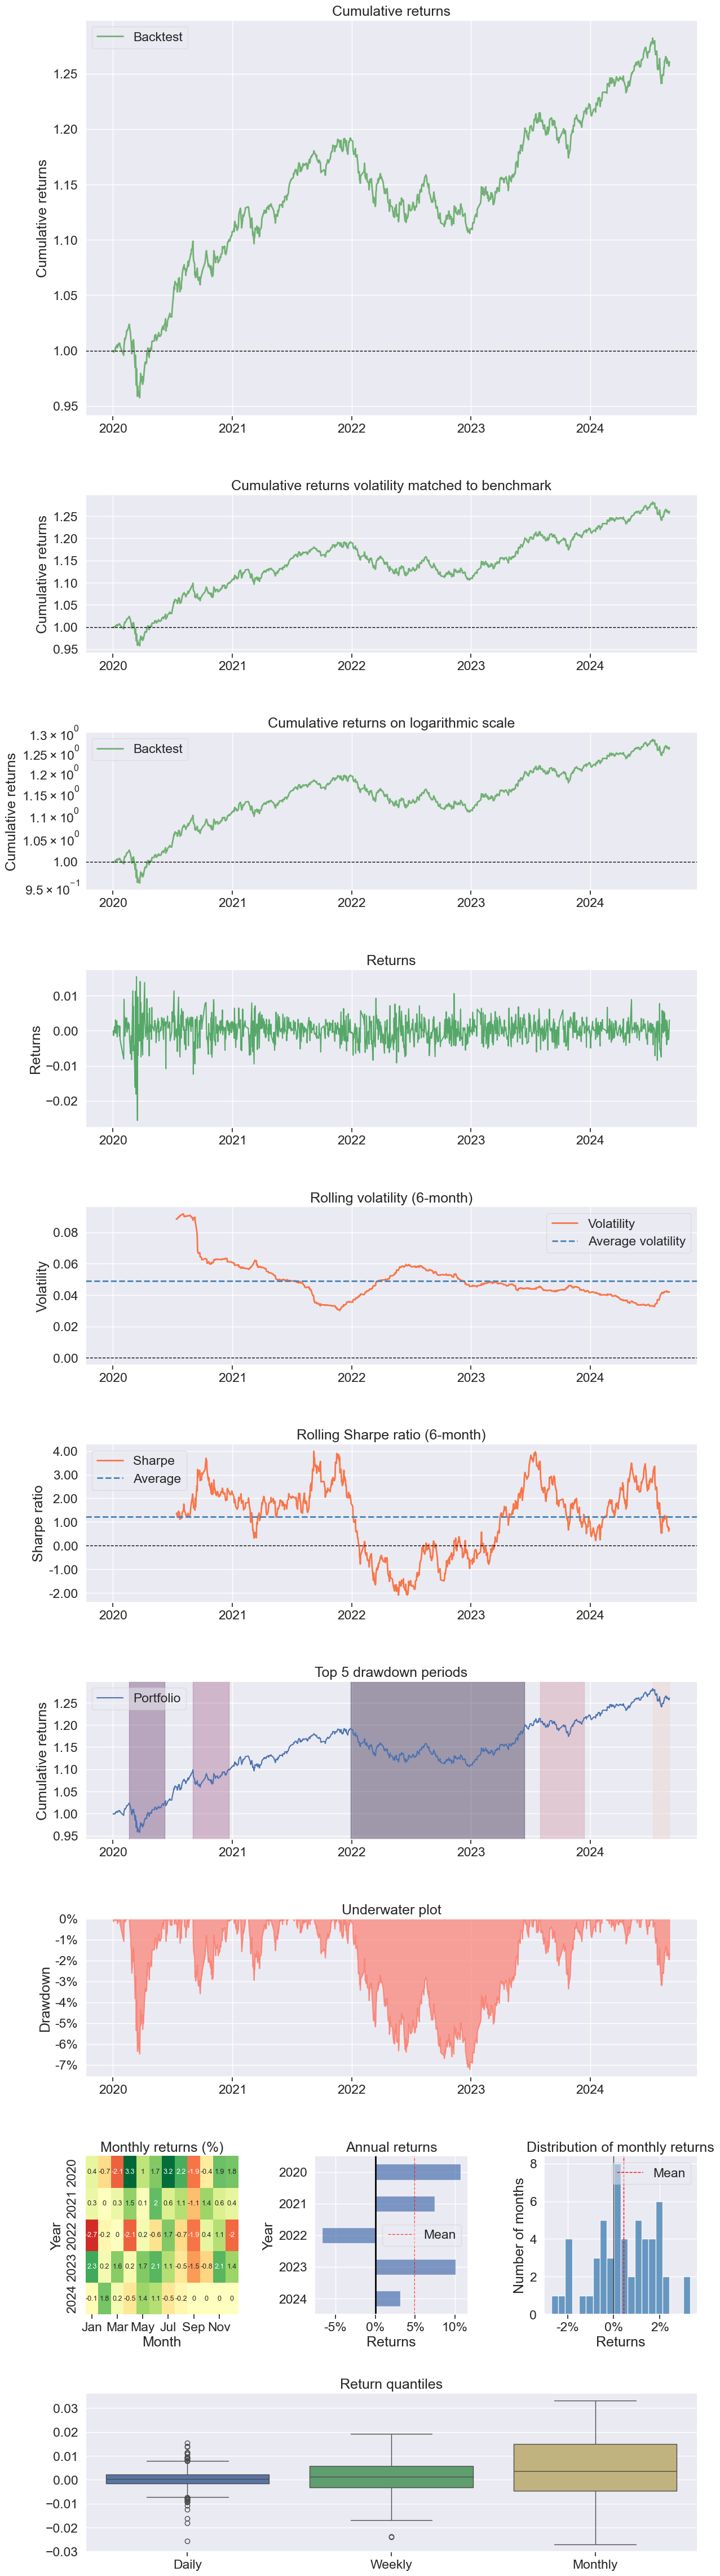

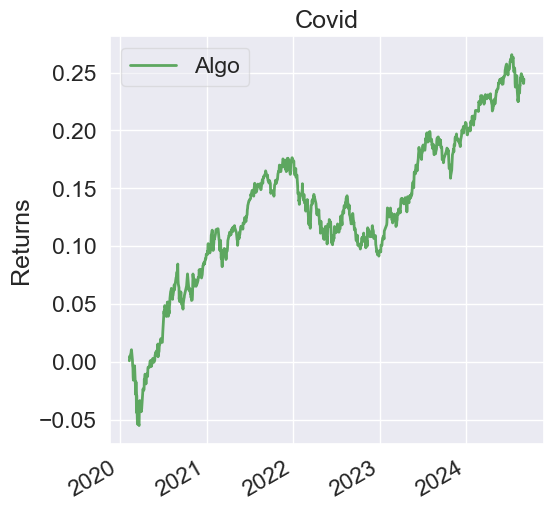

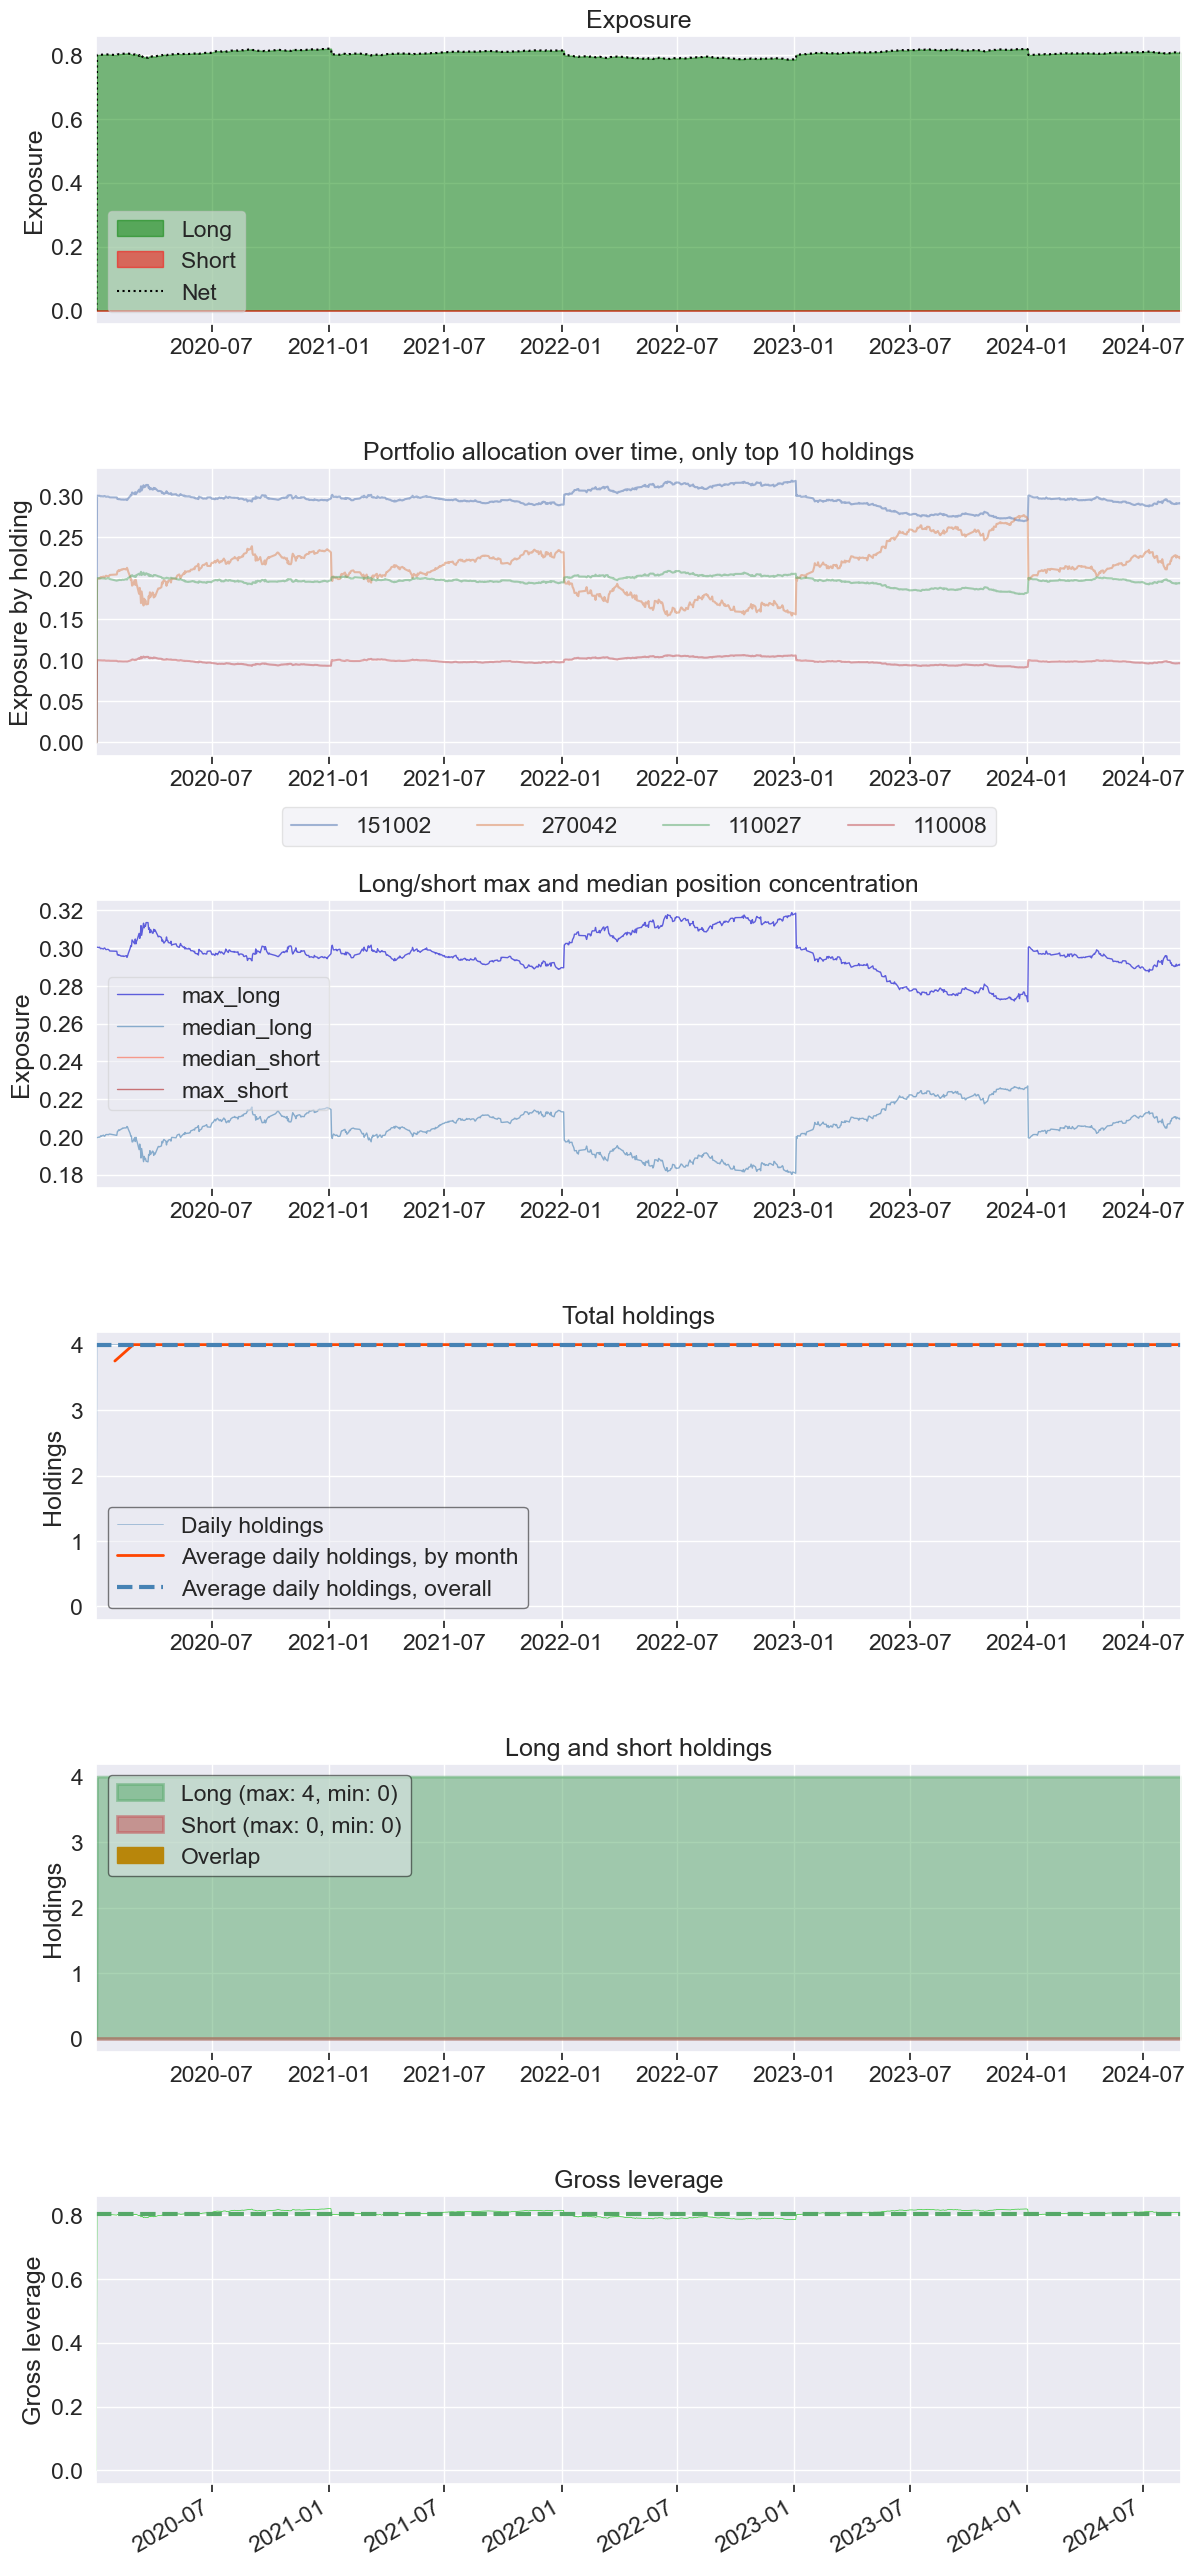

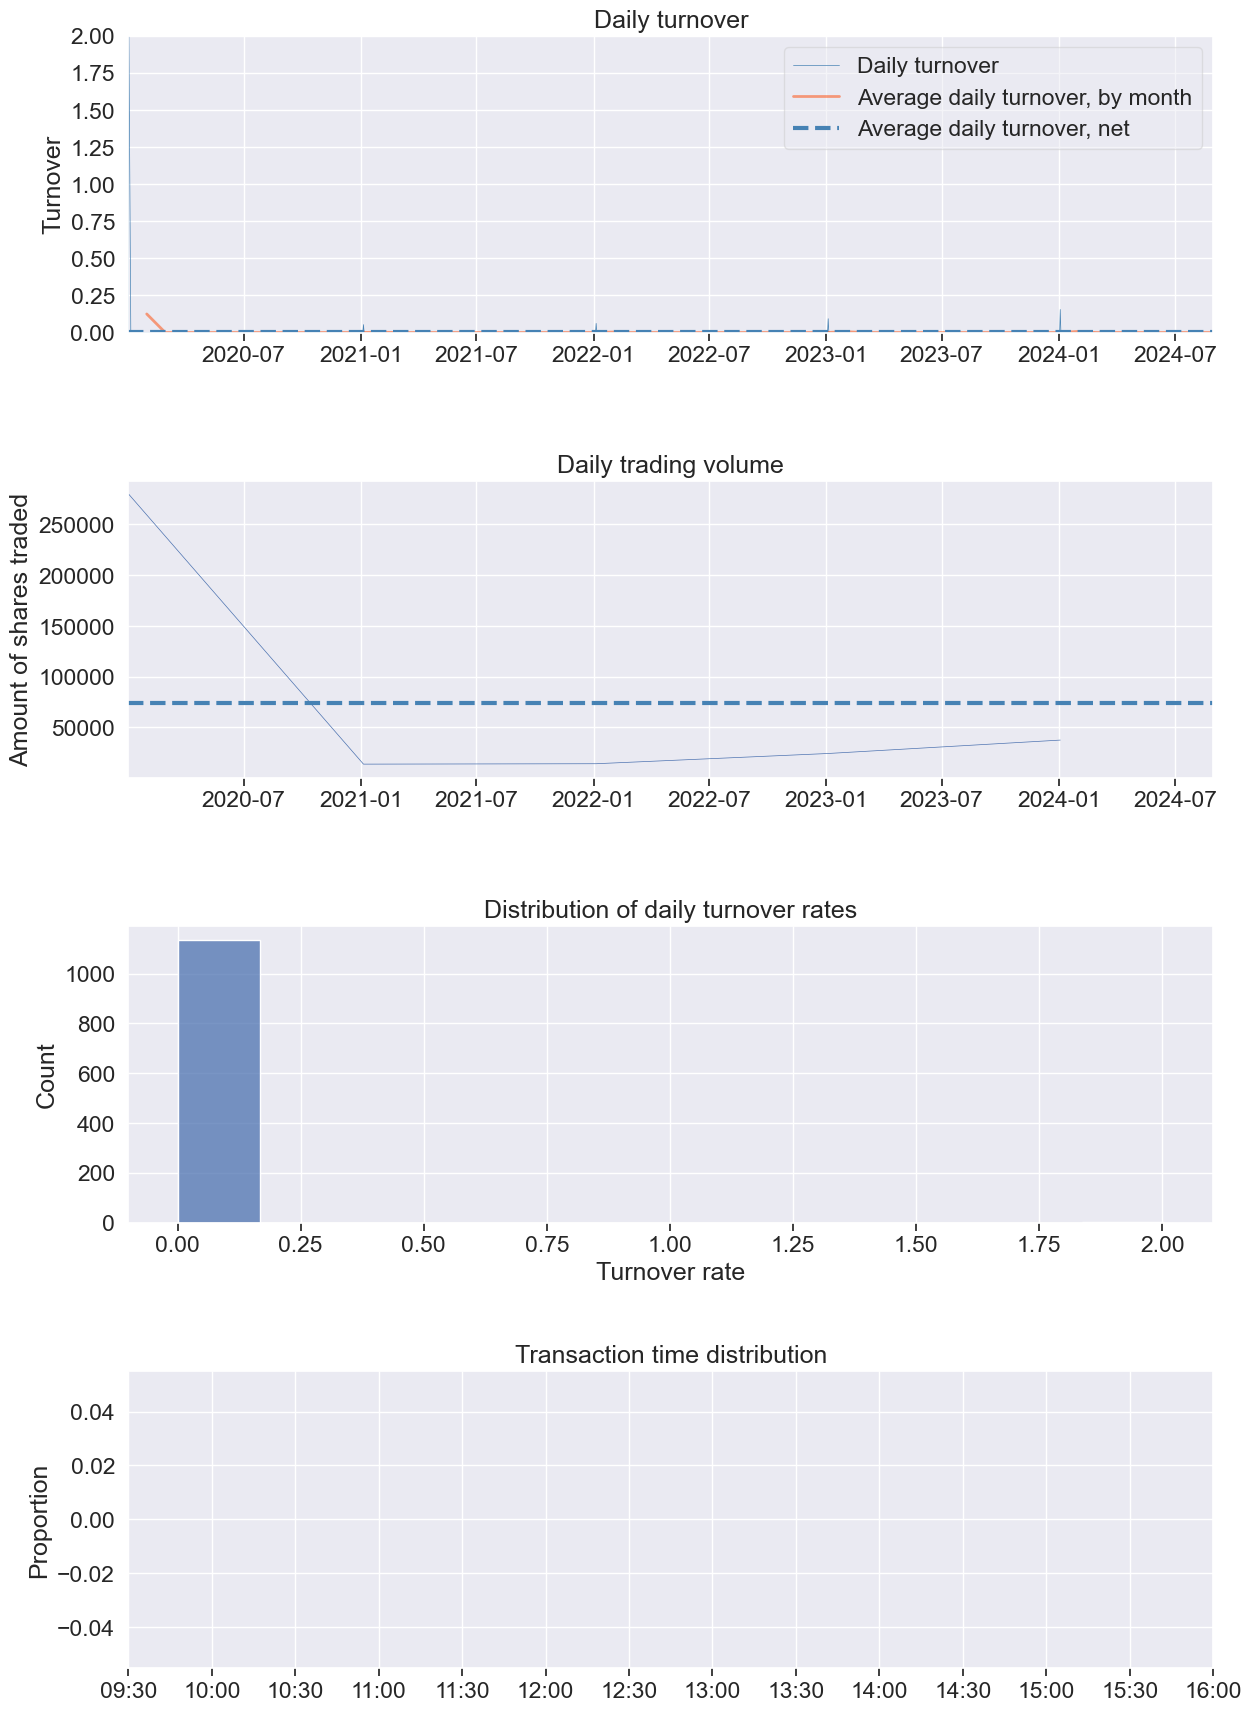

In [71]:
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
# pyfolio showtime
import pyfolio as pf
pf.create_full_tear_sheet(
    returns,
    positions=positions_tracker_results,
    transactions=transactions)

# At this point tables and chart will show up

[*********************100%***********************]  1 of 1 completed


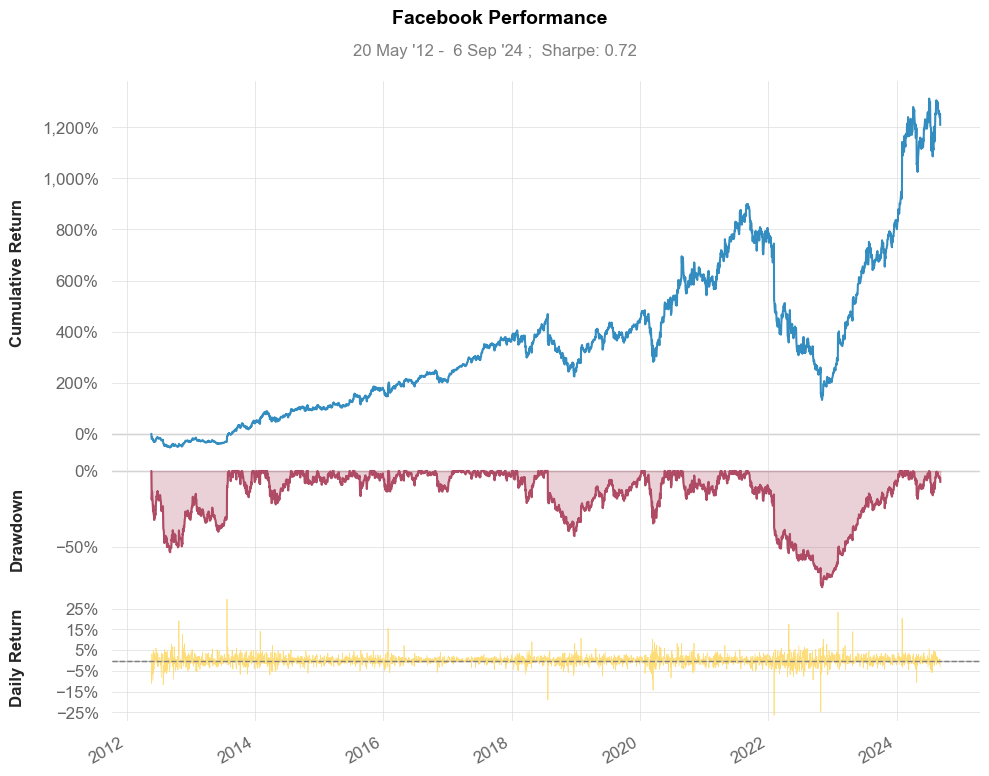

In [20]:
import quantstats as qs

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

# fetch the daily returns for a stock
stock = qs.utils.download_returns('META')
qs.plots.snapshot(stock, title='Facebook Performance')

In [21]:
stock

Date
2012-05-18         NaN
2012-05-21   -0.109861
2012-05-22   -0.089039
2012-05-23    0.032258
2012-05-24    0.032187
                ...   
2024-08-30    0.005963
2024-09-03   -0.018319
2024-09-04    0.001915
2024-09-05    0.008035
2024-09-06   -0.032098
Name: Strategy, Length: 3095, dtype: float64

In [26]:
# (benchmark can be a pandas Series or ticker)
qs.reports.html(stock, # portfolio returns
                "SPY") # benchmark returns

[*********************100%***********************]  1 of 1 completed
D:\Python\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
D:\Python\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
D:\Python\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction